In [87]:
!ls /keyakizaka_mining/data/

Icon?	 faceimages		 feature     profile		test
blog	 faceimages_pad0	 images      ref		tweet
dataset  faceimages_pad0_resize  images.zip  rename_test.ipynb


In [88]:
# path
keyaki_dict_path = '/keyakizaka_mining/data/ref/user_keyahinata_odori.dic'
blog_save_dir = '/keyakizaka_mining/data/blog'
save_tweet_path =  "/keyakizaka_mining/data/tweet"
graph_save_dir = "/keyakizaka_mining/result/blog_graph/"
font_path = "/usr/share/fonts/truetype/takao-gothic/TakaoGothic.ttf"

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import networkx as nx
%config InlineBackend.figure_format = 'retina'

In [90]:

import MeCab
# mecab = MeCab.Tagger("-Ochasen")
mecab = MeCab.Tagger (r"-Ochasen -u %s" % keyaki_dict_path)
mecab.parseToNode( '' )

<MeCab.Node; proxy of <Swig Object of type 'MeCab::Node *' at 0x7fb6bc0cf9c0> >

In [91]:
# japanese plot setting

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font_prop = FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()

In [92]:
def get_odori_words( text ):
    
    if type(text) != str: return [] 
    
    tokens = []
    result = mecab.parseToNode( text )
    while result:
        line = result.feature.split(',')
        tag = line[-1]
        if 'odori' in tag:
            tokens.append( [result.surface, tag] )
        result = result.next
    return tokens

def get_member_words( text ):
    
    if type(text) != str: return [] 
    
    tokens = []
    result = mecab.parseToNode( text )
    while result:
        line = result.feature.split(',')
        tag = line[-1]
        if 'keyakizaka' in tag:
            tokens.append( [result.surface, tag] )
        result = result.next
    return tokens

In [93]:
get_odori_words( '''
みなさんこんにちは٩( ᐛ )و

オードリーの丹生明里(にぶ あかり)です

でもコンタクトって本当に便利ですよね！！！
わたしは中学卒業してからの春休みに出会ったのですが、春日さんの人生が大きく変わりました！
いつまでコンタクトさんにお世話になるかな〜！

コンタクトで思い出したのですが、若林さんにエア舞台マギアレコードの時はピンク色のコンタクトを入れていました！
またピンクになりたいな〜

''')

[['オードリー', 'odori'], ['春日', 'odori_kasuga'], ['若林', 'odori_wakabayashi']]

In [94]:
def extract_df_date_range(df_tmp, start, end):
    df_tmp['datetime'] = pd.to_datetime( df_tmp['datetime'], format='%Y.%m.%d %H:%M' )
    df_tmp = df_tmp.set_index('datetime')
    df_tmp = df_tmp.loc[start:end]
    return df_tmp

In [95]:
def get_relation_odori( df ): 
    mat = np.zeros( ( len(target_members), 3) )
    for i, t in enumerate( df[['author', 'text']].values.tolist()):    
        odotags = get_odori_words(t[1])
        if len( odotags ) == 0: continue
        atag = author2tag[t[0]]
        for inmem in odotags:
            mat[mem2idx[atag], odo2idx[inmem[1]]] += 1.0
    
    dfmat = pd.DataFrame( mat, index=target_members_name, columns=['オードリー','若林','春日'] )
    dfmat.index.name = 'from'
    dfmat.columns.name = 'to'
    return dfmat

def get_relation( df  ): 
    mat = np.zeros( ( len(target_members), len(target_members)) )
    for i, t in enumerate( df[['author', 'text']].values.tolist()):    
        memtags = get_member_words(t[1])
        if len( memtags ) == 0: continue
        atag = author2tag[t[0]]
        memtags_rm = [ i[1] for i in memtags if i[1] != atag]
        for inmem in memtags_rm:
            if not inmem in target_members: continue
            mat[mem2idx[atag], mem2idx[inmem]] += 1.0
    
    dfmat = pd.DataFrame( mat, index=target_members_name, columns=target_members_name )
    dfmat.index.name = 'from'
    dfmat.columns.name = 'to'
    return dfmat

In [96]:
def from_mms_for_df( df ):
    mms = MinMaxScaler()
    df_mms = pd.DataFrame( mms.fit_transform( df ), index=target_members_name, columns=df.columns )
    # df_mms = pd.DataFrame( mms.fit_transform( df.T ).T, index=target_members_name, columns=target_members_name )
    df_mms.index.name = 'from'
    df_mms.columns.name = 'to'
    return df_mms

def to_mms_for_df( df ):
    mms = MinMaxScaler()
    df_mms = pd.DataFrame( mms.fit_transform( df.T ).T, index=target_members_name, columns=df.columns)
    df_mms.index.name = 'from'
    df_mms.columns.name = 'to'
    return df_mms


def chech_heatmap(df):
    plt.figure( figsize=(12, 9), dpi=100 ) 
    sns.heatmap(df, annot=True, fmt="1.0f", linewidths=.5, cmap="Blues")
    plt.show()
    return

def chech_heatmap_normarize(df):
    plt.figure( figsize=(12, 9), dpi=100 ) 
    sns.heatmap(df, annot=True, fmt="1.2f", linewidths=.5, cmap="Blues")
    plt.show()
    return

In [97]:
# gdf file ( Gephi )
def get_gdf_from_networkX( G, fpath ):
    f = open( fpath, 'w', encoding='shift-jis', errors='ignore' )
    # node
    f.write( 'nodedef>name VARCHAR,label VARCHAR,\n')
    name2idx = { name:i for i, name in enumerate( G.nodes )}
    for i, name in enumerate( G.nodes ):
        f.write('%d,%s,\n' % ( i, name ) )

    # edge
    f.write( 'edgedef>node1 VARCHAR,node2 VARCHAR,weight DOUBLE\n' )
    for e in G.edges(data=True):
        f.write('%d,%d,%.3f\n' % (name2idx[e[0]], name2idx[e[1]], e[2]['weight']) )
    f.close()
    
# gml file ( cytoscape )    
def get_gml_from_networkX( G, fpath ):
    f = open( fpath, 'w', encoding='utf-8', errors='ignore' )
    f.write('graph [')
    # node
    name2idx = { name:i for i, name in enumerate( G.nodes )}
    for name, i in name2idx.items():
        f.write('''
          node [
            id %d
            label "%s"
          ]'''
        % ( i, name ))
    
    # edge
    for e in G.edges(data=True):
        f.write('''
          edge [
            source %d
            target %d
            weight %.3f
          ]'''
        % (name2idx[e[0]], name2idx[e[1]], e[2]['weight']) )  
    
    f.write('\n]')
    f.close()
    
# gml file ( cytoscape )    
def get_gml_from_networkX_odori( G, fpath ):
    f = open( fpath, 'w', encoding='utf-8', errors='ignore' )
    f.write('graph [')
    # node
    name2idx = { name:i for i, name in enumerate( G.nodes )}
    for name, i in name2idx.items():
        if name in target_odori_name:
            label = 'Odori'
        else:
            label = 'Member'
        f.write('''
          node [
            id %d
            label "%s"
            odori "%s"
          ]'''
        % ( i, name, label ))
    
    # edge
    for e in G.edges(data=True):
        f.write('''
          edge [
            source %d
            target %d
            weight %.3f
          ]'''
        % (name2idx[e[0]], name2idx[e[1]], e[2]['weight']) )  
    
    f.write('\n]')
    f.close()   

In [98]:
# read blog data

df = pd.read_csv( '%s/hinatazaka46_blog_20190726.csv' % (blog_save_dir) )
print( df.shape )
df.head(1) 

(8529, 6)


,author,datetime,title,text,images,url
0,加藤史帆,2016.8.2 02:50,はじめまして( 。・о・。),はじめまして！ ひらがなけやきの加藤史帆です(｡･υ･)/ﾞ 今月から私たちひ...,https://cdn.hinatazaka46.com/images/14/aff/ed5...,https://www.hinatazaka46.com/s/official/diary/...


In [99]:
author2tag = {}
for i in df['author'].unique().tolist(): # 漢字欅だけにしたいので500件のみ, 卒業メンバ含まない18名
    memwords = get_member_words(i)
    if len(memwords) == 0: continue
    author2tag[i] = memwords[0][1]
target_members_name = [ i for i in author2tag.keys() ]
target_members = [ i for i in author2tag.values() ]
mem2idx = { mem:idx for idx,mem in enumerate( target_members ) }
odo2idx = {
    'odori':0,
    'odori_wakabayashi':1,
    'odori_kasuga':2,
}
target_odori_name = ['オードリー','若林','春日'] 

In [100]:
author2tag

{'加藤史帆': 'keyakizaka_kato',
 '高本彩花': 'keyakizaka_takamoto',
 '潮紗理菜': 'keyakizaka_ushio',
 '高瀬愛奈': 'keyakizaka_takase',
 '柿崎芽実': 'keyakizaka_kakizaki',
 '佐々木久美': 'keyakizaka_sasakikumi',
 '佐々木美玲': 'keyakizaka_sasakimirei',
 '影山優佳': 'keyakizaka_kageyama',
 '井口眞緒': 'keyakizaka_iguchi',
 '齊藤京子': 'keyakizaka_saitokyoko',
 '東村芽依': 'keyakizaka_higashimura',
 '金村美玖': 'keyakizaka_kanemura',
 '小坂菜緒': 'keyakizaka_kosaka',
 '河田陽菜': 'keyakizaka_kawata',
 '濱岸ひより': 'keyakizaka_hamagisi',
 '丹生明里': 'keyakizaka_nibu',
 '富田鈴花': 'keyakizaka_tomita',
 '渡邉美穂': 'keyakizaka_bemiho',
 '宮田愛萌': 'keyakizaka_miyata',
 '松田好花': 'keyakizaka_matsuda',
 '上村ひなの': 'keyakizaka_kamimura'}

In [101]:
df_kanji = df[df['author'].isin( target_members_name )]
df_kanji_targetrange = extract_df_date_range(df_kanji, '2015-01-01', '2020-04-01')

In [102]:
dfmat = get_relation_odori( df_kanji_targetrange )

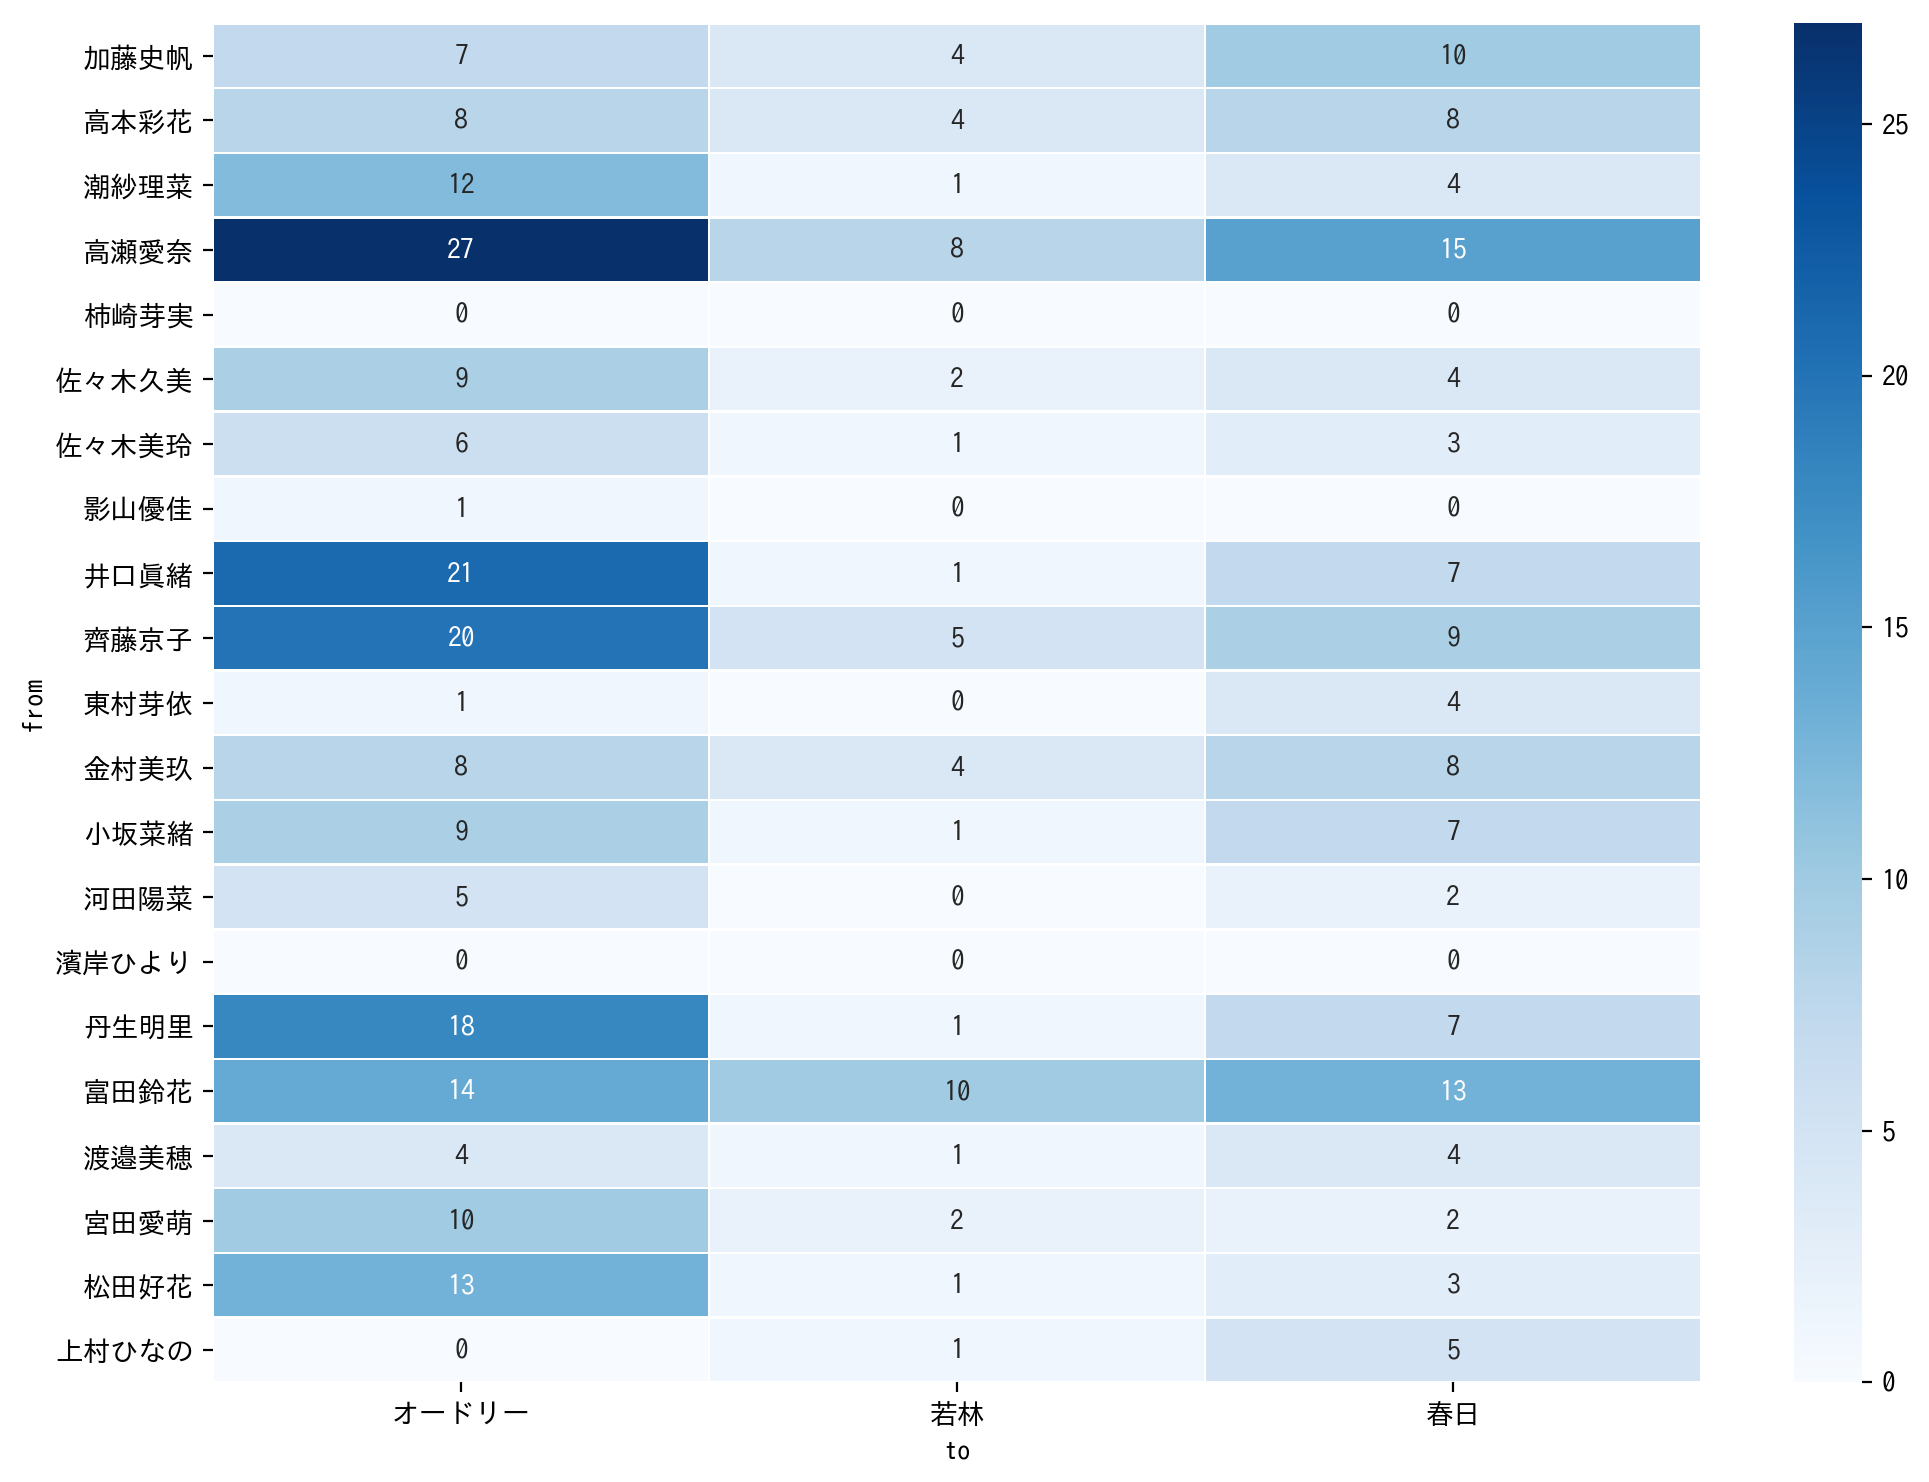

In [103]:
chech_heatmap(dfmat)

In [106]:

targets = {}
mat = dfmat.values
for i in range( len( target_members ) ):
    sorted = np.argsort(mat[i])[::-1]
    sorted_val = np.sort(mat[i])[::-1]
    target = []
    for idx in range( len( sorted ) ):
        target.append( (sorted[idx], sorted_val[idx]) )
    targets[i] = target

G = nx.DiGraph()
for i, target in targets.items() :
    for j in target:
        G.add_edge(target_members_name[i],
                   target_odori_name[j[0]],
                   weight=j[1])

In [107]:
targets

{0: [(2, 10.0), (0, 7.0), (1, 4.0)],
 1: [(2, 8.0), (0, 8.0), (1, 4.0)],
 2: [(0, 12.0), (2, 4.0), (1, 1.0)],
 3: [(0, 27.0), (2, 15.0), (1, 8.0)],
 4: [(2, 0.0), (1, 0.0), (0, 0.0)],
 5: [(0, 9.0), (2, 4.0), (1, 2.0)],
 6: [(0, 6.0), (2, 3.0), (1, 1.0)],
 7: [(0, 1.0), (2, 0.0), (1, 0.0)],
 8: [(0, 21.0), (2, 7.0), (1, 1.0)],
 9: [(0, 20.0), (2, 9.0), (1, 5.0)],
 10: [(2, 4.0), (0, 1.0), (1, 0.0)],
 11: [(2, 8.0), (0, 8.0), (1, 4.0)],
 12: [(0, 9.0), (2, 7.0), (1, 1.0)],
 13: [(0, 5.0), (2, 2.0), (1, 0.0)],
 14: [(2, 0.0), (1, 0.0), (0, 0.0)],
 15: [(0, 18.0), (2, 7.0), (1, 1.0)],
 16: [(0, 14.0), (2, 13.0), (1, 10.0)],
 17: [(2, 4.0), (0, 4.0), (1, 1.0)],
 18: [(0, 10.0), (2, 2.0), (1, 2.0)],
 19: [(0, 13.0), (2, 3.0), (1, 1.0)],
 20: [(2, 5.0), (1, 1.0), (0, 0.0)]}

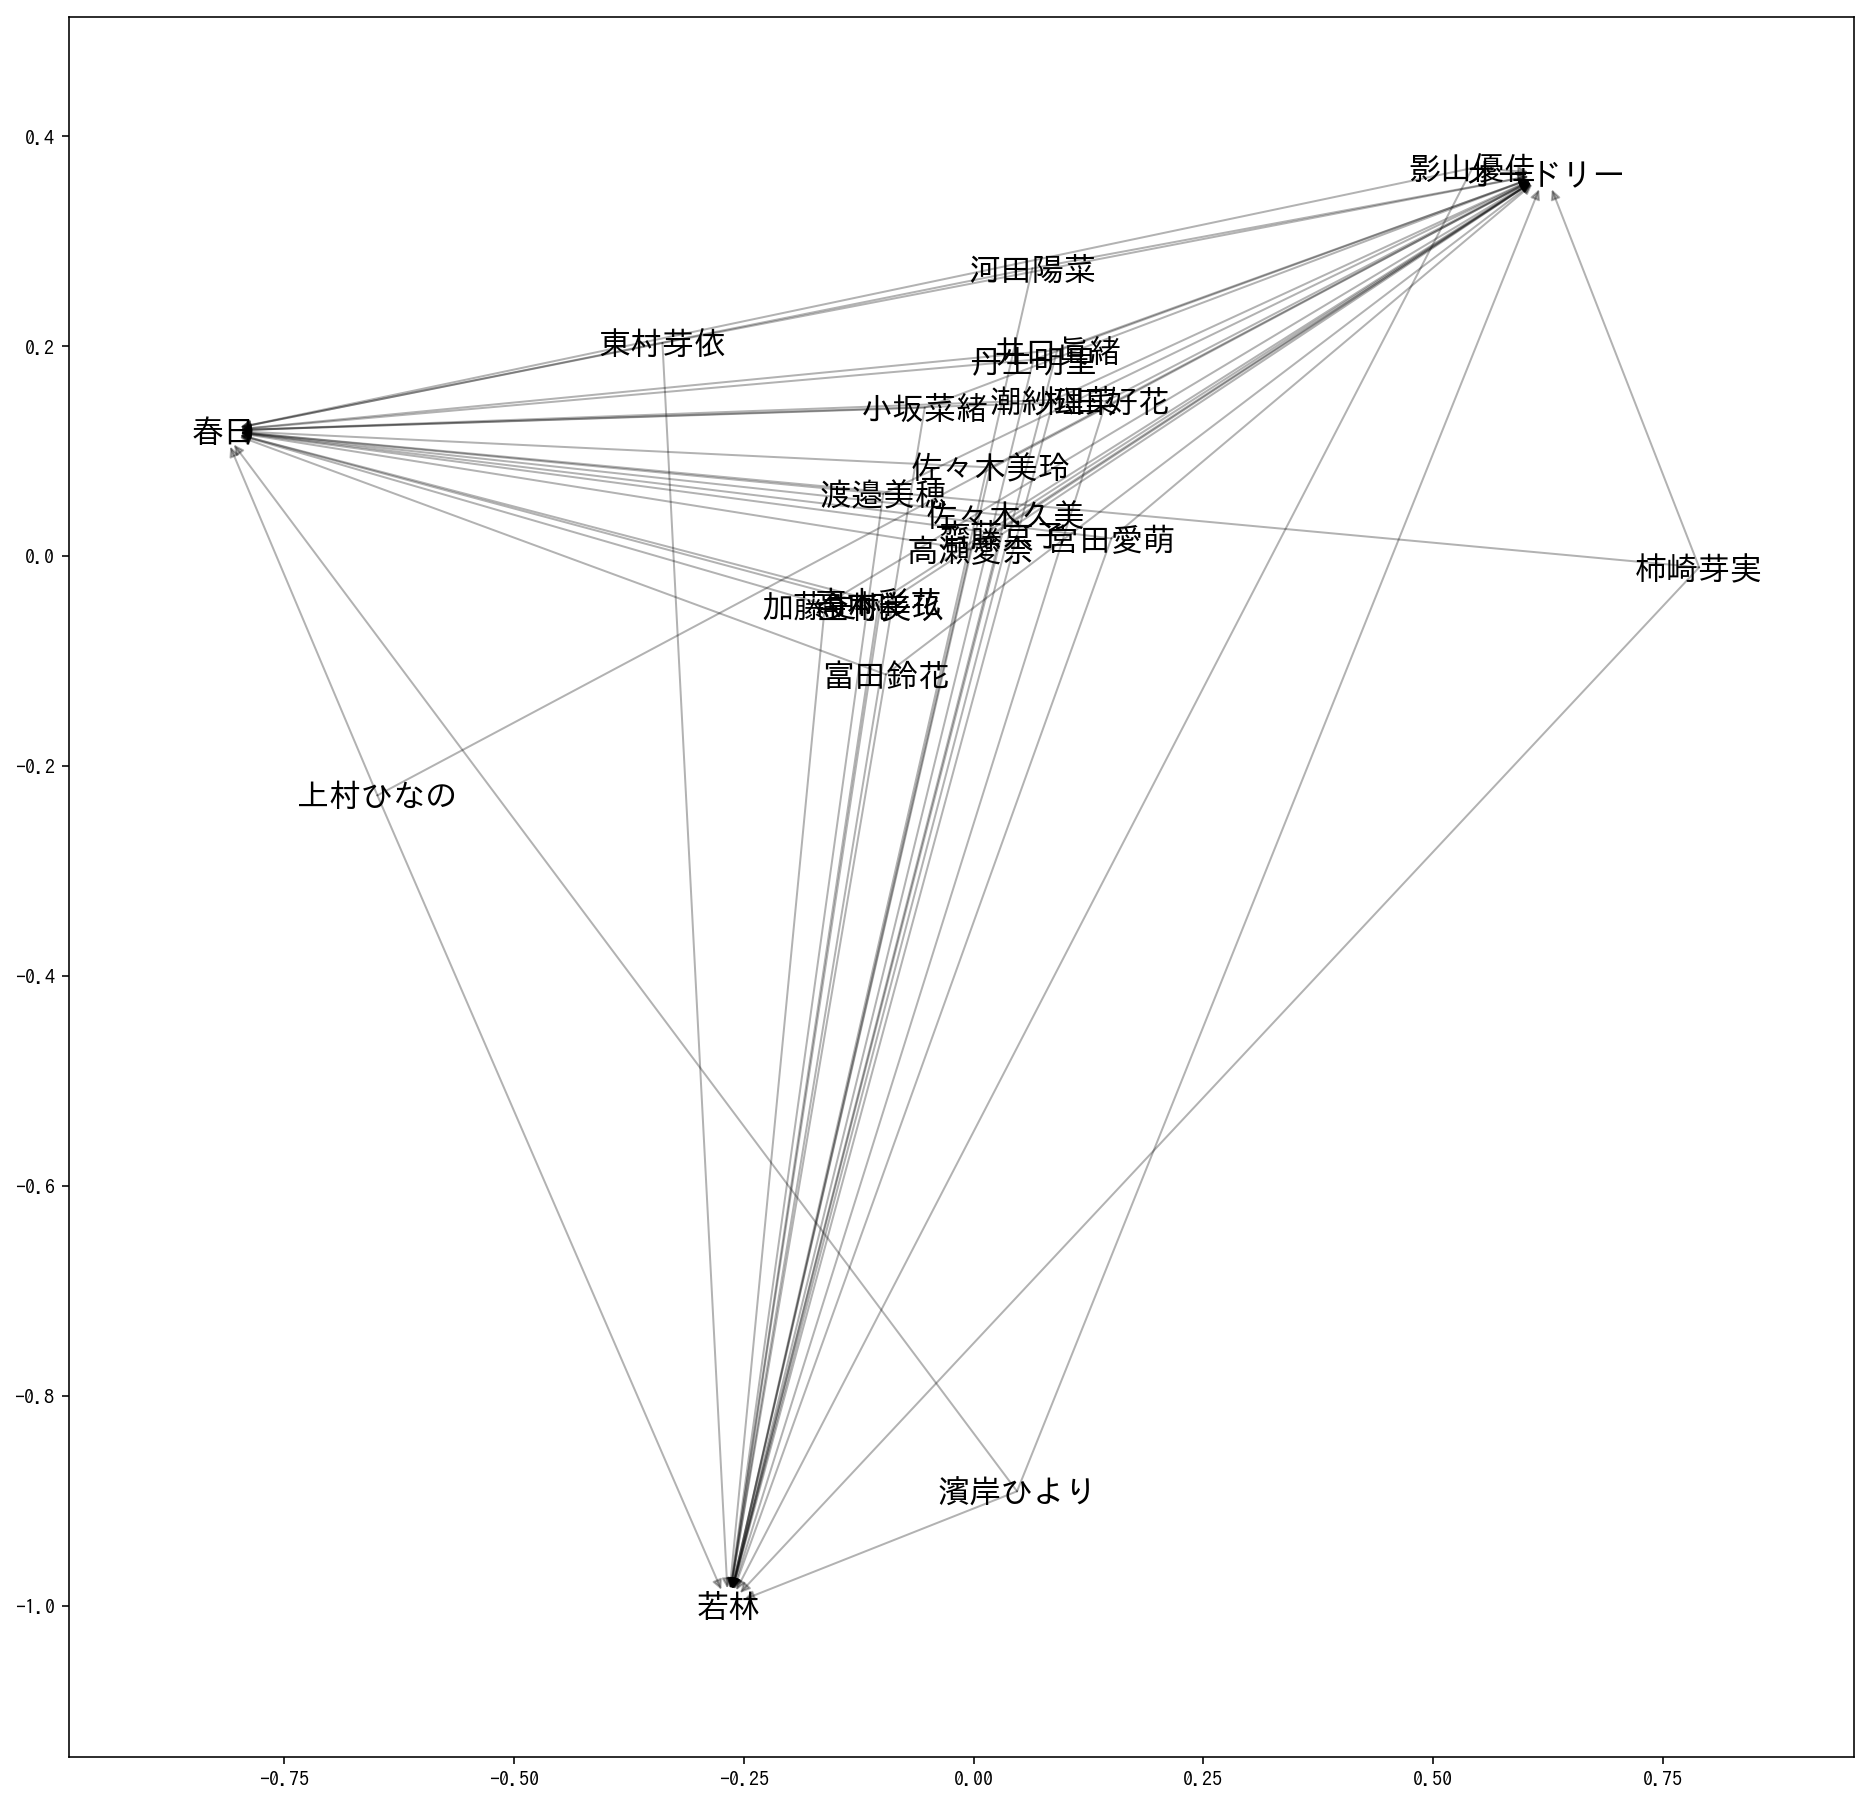

In [108]:
plt.figure(figsize=(16, 16))

pos=nx.spring_layout(G)
nx.draw_networkx_edges(G, pos,alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=16, font_family='TakaoGothic')

plt.show()

In [109]:
get_gdf_from_networkX( G, '%s/graph_Blog_hinata_odori.gdf' % (graph_save_dir) )
get_gml_from_networkX_odori( G, '%s/graph_Blog_hinata_odori.gml' % (graph_save_dir))